In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import foressment_ai as foras

2024-08-30 16:47:01.930136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 16:47:01.930260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 16:47:02.064895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data loading and preprocessing

In [2]:
file_path = '/kaggle/input/machine-failure-prediction-using-sensor-data/data.csv'
df = pd.read_csv(file_path)
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [3]:
for col_name in df:
    print(f'Column: {col_name} has {len(df[col_name].unique())} values.')

Column: footfall has 99 values.
Column: tempMode has 8 values.
Column: AQ has 7 values.
Column: USS has 7 values.
Column: CS has 7 values.
Column: VOC has 7 values.
Column: RP has 71 values.
Column: IP has 7 values.
Column: Temperature has 24 values.
Column: fail has 2 values.


# Create new features
As there are limited numbers of features in the original data set to make the model more suitable for the deep learning model, there is the necessity to expand the feature set; hence we created a new method to enhance feature volumes by adding related interaction features.

## 1. binning

In [4]:
def bin_numeric_column(df, column_name):
    """
    Bin a numeric column in the DataFrame based on the number of unique values.
    
    Parameters:
    - df: pandas DataFrame containing the column to be binned.
    - column_name: The name of the column to bin.
    
    Returns:
    - The DataFrame with a new binned column.
    """
    unique_values = df[column_name].nunique()

    # Determine the number of bins
    if unique_values > 50:
        num_bins = 10
    elif unique_values > 20:
        num_bins = 4
    else:
        return df  
    # Create bins using qcut
    bin_column_name = column_name + '_bin'
    df[bin_column_name], bin_edges = pd.qcut(df[column_name], q=num_bins, labels=False, retbins=True, duplicates='drop')
    
    print(f"Binning {column_name} into {num_bins} bins. Bin edges: {bin_edges}")
    
    return df

In [5]:
df = bin_numeric_column(df, 'footfall')
df = bin_numeric_column(df, 'Temperature')

Binning footfall into 10 bins. Bin edges: [0.00e+00 3.00e+00 1.10e+01 2.20e+01 4.00e+01 7.50e+01 1.74e+02 4.98e+02
 7.30e+03]
Binning Temperature into 4 bins. Bin edges: [ 1. 14. 17. 21. 24.]


## 2. Interaction by multiplication

In [6]:
def create_interaction_features(df, y, threshold=0.2):
    """
    Create interaction features by multiplying each pair of numeric columns.
    Keep only those that have a correlation with y greater than or equal to 0.2.
    
    Parameters:
    - df: pandas DataFrame containing only numeric features.
    - y: pandas Series or array-like representing the target variable.
    
    Returns:
    - Extended DataFrame with selected interaction features.
    """
    extended_df = df.copy()

    for i, col1 in enumerate(df.columns):
        for col2 in df.columns[i+1:]:
            # Create interaction feature by multiplying the columns
            interaction_feature = df[col1] * df[col2]
            feature_name = f"{col1}_x_{col2}"
            
            # Calculate the correlation with y
            correlation = interaction_feature.corr(y)
            
            # Keep feature if the correlation with y is greater than or equal to 0.2
            if abs(correlation) >= 0.2:
                extended_df[feature_name] = interaction_feature
                print(f"Added feature '{feature_name}' with correlation {correlation:.3f} to target.")

    return extended_df

In [7]:
def create_interaction_features_for_binary(df, y, threshold=0.2):
    """
    Create interaction features by multiplying each pair of numeric columns.
    Keep only those that have a point-biserial correlation with y greater than or equal to 0.2.
    
    Parameters:
    - df: pandas DataFrame containing only numeric features.
    - y: pandas Series or array-like representing the binary target variable.
    
    Returns:
    - Extended DataFrame with selected interaction features.
    """
    extended_df = df.copy()

    for i, col1 in enumerate(df.columns):
        for col2 in df.columns[i+1:]:
            interaction_feature = df[col1] * df[col2]
            feature_name = f"{col1}_x_{col2}"
            
            point_biserial_corr = np.corrcoef(interaction_feature, y)[0, 1]
            
            # Keep feature if the point-biserial correlation with y is greater than or equal to 0.2
            if abs(point_biserial_corr) >= threshold:
                extended_df[feature_name] = interaction_feature
                print(f"Added feature '{feature_name}' with point-biserial correlation {point_biserial_corr:.3f} to target.")

    return extended_df

In [8]:
X = df.iloc[:,:-1]
y = df['fail']

In [9]:
X = create_interaction_features_for_binary(X,y)

Added feature 'tempMode_x_AQ' with point-biserial correlation 0.210 to target.
Added feature 'tempMode_x_USS' with point-biserial correlation -0.254 to target.
Added feature 'tempMode_x_VOC' with point-biserial correlation 0.519 to target.
Added feature 'tempMode_x_fail' with point-biserial correlation 0.723 to target.
Added feature 'AQ_x_CS' with point-biserial correlation 0.547 to target.
Added feature 'AQ_x_VOC' with point-biserial correlation 0.802 to target.
Added feature 'AQ_x_RP' with point-biserial correlation 0.405 to target.
Added feature 'AQ_x_IP' with point-biserial correlation 0.505 to target.
Added feature 'AQ_x_Temperature' with point-biserial correlation 0.524 to target.
Added feature 'AQ_x_fail' with point-biserial correlation 0.970 to target.
Added feature 'USS_x_CS' with point-biserial correlation -0.442 to target.
Added feature 'USS_x_VOC' with point-biserial correlation 0.460 to target.
Added feature 'USS_x_RP' with point-biserial correlation -0.349 to target.
Adde

In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
sc = StandardScaler()
X = sc.fit_transform(X)

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.75,stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(708, 39)
(236, 39)
(708,)
(236,)


# Test all Assessor Models

In [12]:
import sys
sys.path.insert(1, '/kaggle/input/models/')
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Recall, Precision, AUC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## DeepCNN

In [14]:
classes = 2
batch_size=32

In [ ]:
import optuna

def create_model(trial):
    blocks = trial.suggest_int("blocks", 1, 2)
    units = trial.suggest_int("units", 32, 256, step=32)
    
    model = foras.DeepCNN(input_shape=(X_train.shape[1],1), blocks=blocks, units=units, classes=classes)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size, 
              validation_data=(X_test, y_test))
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=18)

print("Best blocks:", study.best_trial.params["blocks"]) 
print("Best units:", study.best_trial.params["units"])

[I 2024-08-30 16:47:15,028] A new study created in memory with name: no-name-b11dee4f-1b83-4b9f-81fd-5b1eb8c11ae8
I0000 00:00:1725036443.162759      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725036443.189193      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9536 - auc: 1.0000 - loss: 0.3205 - precision: 1.0000 - recall: 0.8896 


[I 2024-08-30 16:47:28,597] Trial 0 finished with value: 0.9491525292396545 and parameters: {'blocks': 2, 'units': 128}. Best is trial 0 with value: 0.9491525292396545.
W0000 00:00:1725036452.959946      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725036454.531253      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725036455.591878      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9861 - auc: 1.0000 - loss: 0.2934 - precision_1: 1.0000 - recall_1: 0.9672 


[I 2024-08-30 16:47:36,869] Trial 1 finished with value: 0.9830508232116699 and parameters: {'blocks': 1, 'units': 192}. Best is trial 1 with value: 0.9830508232116699.
W0000 00:00:1725036462.791738      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - auc: 1.0000 - loss: 0.2785 - precision_2: 1.0000 - recall_2: 0.9379 


[I 2024-08-30 16:47:45,486] Trial 2 finished with value: 0.9661017060279846 and parameters: {'blocks': 1, 'units': 224}. Best is trial 1 with value: 0.9830508232116699.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9721 - auc: 0.9982 - loss: 0.3467 - precision_3: 0.9931 - recall_3: 0.9405 


[I 2024-08-30 16:47:56,482] Trial 3 finished with value: 0.9618644118309021 and parameters: {'blocks': 2, 'units': 64}. Best is trial 1 with value: 0.9830508232116699.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9772 - auc: 0.9971 - loss: 0.2859 - precision_4: 0.9932 - recall_4: 0.9528 


[I 2024-08-30 16:48:07,458] Trial 4 finished with value: 0.9703390002250671 and parameters: {'blocks': 2, 'units': 32}. Best is trial 1 with value: 0.9830508232116699.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9890 - auc: 0.9996 - loss: 0.3322 - precision_5: 0.9935 - recall_5: 0.9805 


[I 2024-08-30 16:48:19,064] Trial 5 finished with value: 0.9872881174087524 and parameters: {'blocks': 2, 'units': 96}. Best is trial 5 with value: 0.9872881174087524.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9547 - auc: 1.0000 - loss: 0.3784 - precision_6: 1.0000 - recall_6: 0.8923 


[I 2024-08-30 16:48:29,042] Trial 6 finished with value: 0.9491525292396545 and parameters: {'blocks': 2, 'units': 64}. Best is trial 5 with value: 0.9872881174087524.
W0000 00:00:1725036514.711626      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9872 - auc: 0.9997 - loss: 0.2439 - precision_7: 0.9788 - recall_7: 0.9915 


[I 2024-08-30 16:48:39,277] Trial 7 finished with value: 0.9872881174087524 and parameters: {'blocks': 2, 'units': 128}. Best is trial 5 with value: 0.9872881174087524.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - auc: 0.9998 - loss: 0.3381 - precision_8: 1.0000 - recall_8: 0.9915 


[I 2024-08-30 16:48:48,606] Trial 8 finished with value: 0.9957627058029175 and parameters: {'blocks': 2, 'units': 64}. Best is trial 8 with value: 0.9957627058029175.
W0000 00:00:1725036534.146242      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2402 - precision_9: 1.0000 - recall_9: 1.0000 


[I 2024-08-30 16:48:56,080] Trial 9 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 224}. Best is trial 9 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2605 - precision_10: 1.0000 - recall_10: 1.0000 


[I 2024-08-30 16:49:04,369] Trial 10 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 256}. Best is trial 9 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9733 - auc: 1.0000 - loss: 0.2831 - precision_11: 1.0000 - recall_11: 0.9372 


[I 2024-08-30 16:49:11,235] Trial 11 finished with value: 0.9703390002250671 and parameters: {'blocks': 1, 'units': 256}. Best is trial 9 with value: 1.0.
W0000 00:00:1725036554.960587      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725036556.096790      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725036557.030100      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2798 - precision_12: 1.0000 - recall_12: 1.0000 


[I 2024-08-30 16:49:18,058] Trial 12 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 192}. Best is trial 9 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - auc: 1.0000 - loss: 0.2442 - precision_13: 1.0000 - recall_13: 0.9379 


[I 2024-08-30 16:49:24,990] Trial 13 finished with value: 0.9661017060279846 and parameters: {'blocks': 1, 'units': 256}. Best is trial 9 with value: 1.0.
W0000 00:00:1725036569.506355      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725036570.641119      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725036571.578466      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.2602 - precision_14: 1.0000 - recall_14: 0.9915 


[I 2024-08-30 16:49:32,632] Trial 14 finished with value: 0.9957627058029175 and parameters: {'blocks': 1, 'units': 192}. Best is trial 9 with value: 1.0.
W0000 00:00:1725036577.652299      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9784 - auc: 1.0000 - loss: 0.2259 - precision_15: 1.0000 - recall_15: 0.9489 


[I 2024-08-30 16:49:39,646] Trial 15 finished with value: 0.9703390002250671 and parameters: {'blocks': 1, 'units': 224}. Best is trial 9 with value: 1.0.
W0000 00:00:1725036584.621184      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2148 - precision_16: 1.0000 - recall_16: 1.0000 


[I 2024-08-30 16:49:46,597] Trial 16 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 224}. Best is trial 9 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - auc: 1.0000 - loss: 0.2341 - precision_17: 1.0000 - recall_17: 0.9783 


[I 2024-08-30 16:49:54,794] Trial 17 finished with value: 0.9872881174087524 and parameters: {'blocks': 1, 'units': 160}. Best is trial 9 with value: 1.0.


Best blocks: 1
Best units: 224


In [16]:
model_one = foras.DeepCNN(input_shape=(X_train.shape[1],1), blocks=study.best_trial.params["blocks"], units=study.best_trial.params["units"], classes=classes)
hist_train = model_one.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=batch_size, verbose=0)

W0000 00:00:1725036599.722312      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


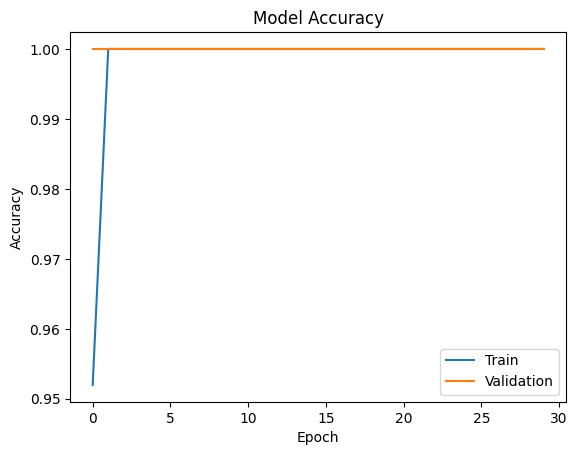

In [17]:
model_one.draw_plot(plot_type="accuracy")

In [18]:
model_one.test(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.5858e-05 - precision_18: 1.0000 - recall_18: 1.0000 


[7.26959842722863e-05, 1.0, 1.0, 1.0, 1.0]

## CNN+GRU

In [ ]:
import optuna

def create_model(trial):
    units = trial.suggest_int("units", 32, 256, step=32)
    model = foras.Hybrid_CNN_GRU(input_shape=(X_train.shape[1],1), units=units, classes=classes)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, 
              validation_data=(X_test, y_test), batch_size=batch_size)
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=9)

print("Best units:", study.best_trial.params["units"])

[I 2024-08-30 16:50:05,542] A new study created in memory with name: no-name-562c27d3-5b4e-4d5c-bf3f-5ebaef96a20e


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4640 - auc: 0.9606 - loss: 0.6549 - precision_19: 0.4396 - recall_19: 1.0000 


[I 2024-08-30 16:50:18,416] Trial 0 finished with value: 0.4830508530139923 and parameters: {'units': 32}. Best is trial 0 with value: 0.4830508530139923.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4198 - auc: 0.9992 - loss: 0.7724 - precision_20: 0.4198 - recall_20: 1.0000 


[I 2024-08-30 16:50:27,441] Trial 1 finished with value: 0.41525423526763916 and parameters: {'units': 224}. Best is trial 0 with value: 0.4830508530139923.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6597 - auc: 0.9991 - loss: 0.5679 - precision_21: 0.5532 - recall_21: 1.0000 


[I 2024-08-30 16:50:35,379] Trial 2 finished with value: 0.6737288236618042 and parameters: {'units': 192}. Best is trial 2 with value: 0.6737288236618042.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9838 - auc: 0.9981 - loss: 0.4879 - precision_22: 0.9786 - recall_22: 0.9833 


[I 2024-08-30 16:50:42,831] Trial 3 finished with value: 0.9788135886192322 and parameters: {'units': 192}. Best is trial 3 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5625 - auc: 0.9989 - loss: 0.5854 - precision_23: 0.4899 - recall_23: 1.0000 


[I 2024-08-30 16:50:50,600] Trial 4 finished with value: 0.5720338821411133 and parameters: {'units': 128}. Best is trial 3 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4198 - auc: 0.9970 - loss: 0.6855 - precision_24: 0.4198 - recall_24: 1.0000 


[I 2024-08-30 16:50:58,228] Trial 5 finished with value: 0.41525423526763916 and parameters: {'units': 96}. Best is trial 3 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9769 - auc: 0.9981 - loss: 0.5131 - precision_25: 0.9932 - recall_25: 0.9519 


[I 2024-08-30 16:51:07,114] Trial 6 finished with value: 0.9661017060279846 and parameters: {'units': 160}. Best is trial 3 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - auc: 0.9577 - loss: 0.4555 - precision_26: 0.9584 - recall_26: 0.7191 


[I 2024-08-30 16:51:14,405] Trial 7 finished with value: 0.8601694703102112 and parameters: {'units': 32}. Best is trial 3 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8776 - auc: 0.9673 - loss: 0.5291 - precision_27: 0.9655 - recall_27: 0.7350 


[I 2024-08-30 16:51:21,514] Trial 8 finished with value: 0.8728813529014587 and parameters: {'units': 32}. Best is trial 3 with value: 0.9788135886192322.


Best units: 192


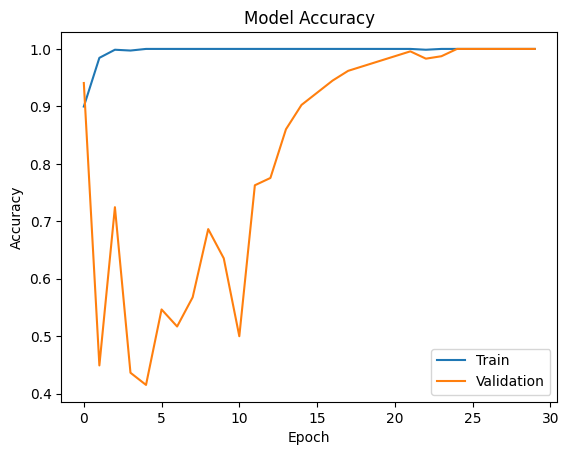

In [21]:
hybrid_classifier = foras.Hybrid_CNN_GRU(input_shape=(X_train.shape[1],1), units=study.best_trial.params["units"], classes=classes)
hist_train = hybrid_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=batch_size, verbose=0)
hybrid_classifier.draw_plot(plot_type="accuracy")

In [22]:
hybrid_classifier.test(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.7845e-04 - precision_28: 1.0000 - recall_28: 1.0000 


[0.00046391127398237586, 1.0, 1.0, 1.0, 1.0]

## Variations

In [24]:
import optuna

def create_model(trial):
    blocks = trial.suggest_int("blocks", 1, 2)
    units = trial.suggest_int("units", 32, 256, step=32)
    
    model = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=units, classes=classes, block="residual", loop_number=blocks)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size, 
              validation_data=(X_test, y_test))
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=18)

print("Best blocks:", study.best_trial.params["blocks"]) 
print("Best units:", study.best_trial.params["units"])

[I 2024-08-30 16:51:38,256] A new study created in memory with name: no-name-dbb07251-ca5d-4063-b47c-78555360bbbc


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - auc: 1.0000 - loss: 0.0869 - precision_29: 1.0000 - recall_29: 0.9867 


[I 2024-08-30 16:51:53,118] Trial 0 finished with value: 0.991525411605835 and parameters: {'blocks': 2, 'units': 160}. Best is trial 0 with value: 0.991525411605835.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - auc: 0.9997 - loss: 0.1002 - precision_30: 1.0000 - recall_30: 0.9893 


[I 2024-08-30 16:52:07,399] Trial 1 finished with value: 0.991525411605835 and parameters: {'blocks': 2, 'units': 32}. Best is trial 0 with value: 0.991525411605835.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0806 - precision_31: 1.0000 - recall_31: 1.0000 


[I 2024-08-30 16:52:23,390] Trial 2 finished with value: 1.0 and parameters: {'blocks': 2, 'units': 192}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.0769 - precision_32: 1.0000 - recall_32: 0.9915 


[I 2024-08-30 16:52:35,247] Trial 3 finished with value: 0.9957627058029175 and parameters: {'blocks': 1, 'units': 256}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9732 - auc: 1.0000 - loss: 0.2153 - precision_33: 1.0000 - recall_33: 0.9367 


[I 2024-08-30 16:52:50,047] Trial 4 finished with value: 0.9661017060279846 and parameters: {'blocks': 2, 'units': 224}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - auc: 1.0000 - loss: 0.1391 - precision_34: 1.0000 - recall_34: 0.9831 


[I 2024-08-30 16:53:04,350] Trial 5 finished with value: 0.991525411605835 and parameters: {'blocks': 2, 'units': 256}. Best is trial 2 with value: 1.0.
W0000 00:00:1725036793.449313      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.1157 - precision_35: 1.0000 - recall_35: 0.9915 


[I 2024-08-30 16:53:15,845] Trial 6 finished with value: 0.9957627058029175 and parameters: {'blocks': 1, 'units': 128}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0769 - precision_36: 1.0000 - recall_36: 1.0000 


[I 2024-08-30 16:53:28,919] Trial 7 finished with value: 1.0 and parameters: {'blocks': 2, 'units': 256}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0650 - precision_37: 1.0000 - recall_37: 1.0000 


[I 2024-08-30 16:53:42,138] Trial 8 finished with value: 1.0 and parameters: {'blocks': 2, 'units': 32}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0445 - precision_38: 1.0000 - recall_38: 1.0000 


[I 2024-08-30 16:53:56,674] Trial 9 finished with value: 1.0 and parameters: {'blocks': 2, 'units': 64}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - auc: 1.0000 - loss: 0.1203 - precision_39: 1.0000 - recall_39: 0.9721 


[I 2024-08-30 16:54:09,616] Trial 10 finished with value: 0.9872881174087524 and parameters: {'blocks': 1, 'units': 160}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.0785 - precision_40: 1.0000 - recall_40: 0.9915 


[I 2024-08-30 16:54:22,587] Trial 11 finished with value: 0.9957627058029175 and parameters: {'blocks': 2, 'units': 192}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0732 - precision_41: 1.0000 - recall_41: 1.0000 


[I 2024-08-30 16:54:35,699] Trial 12 finished with value: 1.0 and parameters: {'blocks': 2, 'units': 224}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1460 - precision_42: 1.0000 - recall_42: 1.0000 


[I 2024-08-30 16:54:48,649] Trial 13 finished with value: 1.0 and parameters: {'blocks': 2, 'units': 192}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.0875 - precision_43: 1.0000 - recall_43: 0.9915 


[I 2024-08-30 16:55:00,536] Trial 14 finished with value: 0.9957627058029175 and parameters: {'blocks': 1, 'units': 96}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - auc: 1.0000 - loss: 0.1301 - precision_44: 1.0000 - recall_44: 0.9432 


[I 2024-08-30 16:55:13,753] Trial 15 finished with value: 0.9618644118309021 and parameters: {'blocks': 2, 'units': 224}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - auc: 1.0000 - loss: 0.1664 - precision_45: 1.0000 - recall_45: 0.9831 


[I 2024-08-30 16:55:26,869] Trial 16 finished with value: 0.991525411605835 and parameters: {'blocks': 2, 'units': 192}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0846 - precision_46: 1.0000 - recall_46: 1.0000 


[I 2024-08-30 16:55:37,060] Trial 17 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 256}. Best is trial 2 with value: 1.0.


Best blocks: 2
Best units: 192


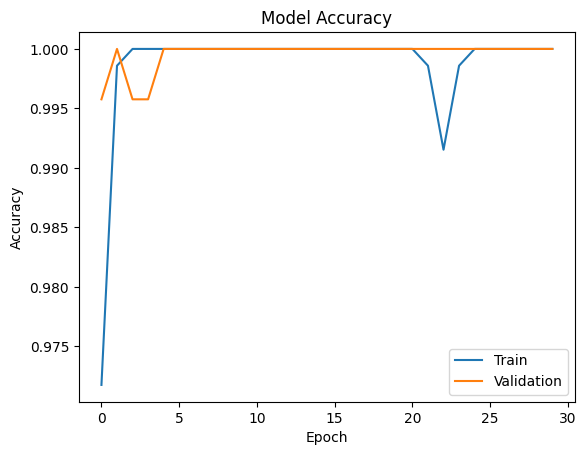

In [25]:
hybrid_ = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=study.best_trial.params["units"], classes=classes, block="residual", loop_number=study.best_trial.params["blocks"])
hist_train = hybrid_.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=batch_size, verbose=0)
hybrid_.draw_plot(plot_type="accuracy")

In [26]:
hybrid_.test(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.5267e-09 - precision_47: 1.0000 - recall_47: 1.0000 


[8.267987183785408e-09, 1.0, 1.0, 1.0, 1.0]

In [ ]:
import optuna

def create_model(trial):
    blocks = trial.suggest_int("blocks", 1, 2)
    units = trial.suggest_int("units", 32, 256, step=32)
    
    model = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=units, classes=classes, block="Xception", loop_number=blocks)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size, 
              validation_data=(X_test, y_test))
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=18)

print("Best blocks:", study.best_trial.params["blocks"]) 
print("Best units:", study.best_trial.params["units"])

[I 2024-08-30 16:55:54,890] A new study created in memory with name: no-name-82037c95-f3bb-4fe6-bc95-d3a0bd142d06


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - auc: 0.9991 - loss: 0.2730 - precision_48: 1.0000 - recall_48: 0.9634 


[I 2024-08-30 16:56:17,265] Trial 0 finished with value: 0.9788135886192322 and parameters: {'blocks': 2, 'units': 128}. Best is trial 0 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9627 - auc: 0.9973 - loss: 0.3441 - precision_49: 0.9288 - recall_49: 0.9867 


[I 2024-08-30 16:56:37,802] Trial 1 finished with value: 0.9491525292396545 and parameters: {'blocks': 2, 'units': 96}. Best is trial 0 with value: 0.9788135886192322.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1091 - precision_50: 1.0000 - recall_50: 1.0000 


[I 2024-08-30 16:56:51,509] Trial 2 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 32}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9697 - auc: 1.0000 - loss: 0.2640 - precision_51: 1.0000 - recall_51: 0.9287 


[I 2024-08-30 16:57:11,655] Trial 3 finished with value: 0.9661017060279846 and parameters: {'blocks': 2, 'units': 64}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - auc: 0.9999 - loss: 0.3405 - precision_52: 1.0000 - recall_52: 0.9634 


[I 2024-08-30 16:57:30,906] Trial 4 finished with value: 0.9788135886192322 and parameters: {'blocks': 2, 'units': 160}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - auc: 0.9997 - loss: 0.2543 - precision_53: 1.0000 - recall_53: 0.9391 


[I 2024-08-30 16:57:50,253] Trial 5 finished with value: 0.9661017060279846 and parameters: {'blocks': 2, 'units': 224}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9900 - auc: 0.9993 - loss: 0.2786 - precision_54: 0.9791 - recall_54: 0.9977 


[I 2024-08-30 16:58:06,901] Trial 6 finished with value: 0.9788135886192322 and parameters: {'blocks': 2, 'units': 160}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9676 - auc: 0.9996 - loss: 0.2174 - precision_55: 1.0000 - recall_55: 0.9239 


[I 2024-08-30 16:58:23,934] Trial 7 finished with value: 0.9618644118309021 and parameters: {'blocks': 2, 'units': 128}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - auc: 0.9998 - loss: 0.3011 - precision_56: 1.0000 - recall_56: 0.9977 


[I 2024-08-30 16:58:43,088] Trial 8 finished with value: 0.9957627058029175 and parameters: {'blocks': 2, 'units': 32}. Best is trial 2 with value: 1.0.
W0000 00:00:1725037132.281152      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725037135.986255      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725037137.159951      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1146 - precision_57: 1.0000 - recall_57: 1.0000 


[I 2024-08-30 16:58:58,580] Trial 9 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 96}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1125 - precision_58: 1.0000 - recall_58: 1.0000 


[I 2024-08-30 16:59:11,848] Trial 10 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 256}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1415 - precision_59: 1.0000 - recall_59: 1.0000 


[I 2024-08-30 16:59:23,197] Trial 11 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 32}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1448 - precision_60: 1.0000 - recall_60: 1.0000 


[I 2024-08-30 16:59:37,483] Trial 12 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 64}. Best is trial 2 with value: 1.0.
W0000 00:00:1725037183.726160      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725037186.883382      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725037187.887594      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0927 - precision_61: 1.0000 - recall_61: 1.0000 


[I 2024-08-30 16:59:49,174] Trial 13 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 96}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1190 - precision_62: 1.0000 - recall_62: 1.0000 


[I 2024-08-30 17:00:00,756] Trial 14 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 64}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1805 - precision_63: 1.0000 - recall_63: 1.0000 


[I 2024-08-30 17:00:12,305] Trial 15 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 32}. Best is trial 2 with value: 1.0.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0835 - precision_64: 1.0000 - recall_64: 1.0000 


[I 2024-08-30 17:00:26,109] Trial 16 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 192}. Best is trial 2 with value: 1.0.
W0000 00:00:1725037232.327962      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725037235.455970      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725037236.480189      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1377 - precision_65: 1.0000 - recall_65: 1.0000 


[I 2024-08-30 17:00:37,722] Trial 17 finished with value: 1.0 and parameters: {'blocks': 1, 'units': 96}. Best is trial 2 with value: 1.0.


Best blocks: 1
Best units: 32


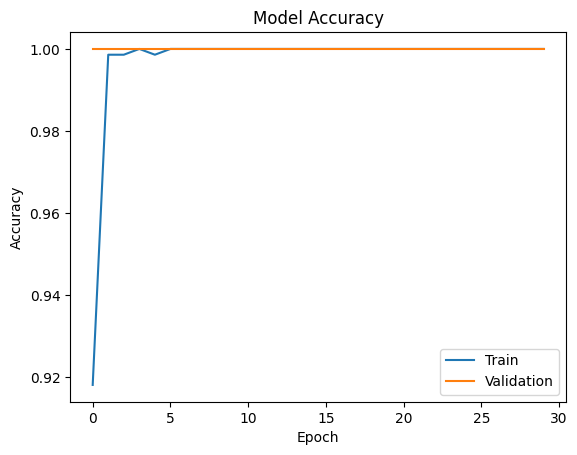

In [28]:
hybrid_x = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=study.best_trial.params["units"], classes=classes, block="Xception", loop_number=study.best_trial.params["blocks"])
hist_train = hybrid_x.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=batch_size, verbose=0)
hybrid_x.draw_plot(plot_type="accuracy")

In [29]:
hybrid_x.test(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.3545e-05 - precision_66: 1.0000 - recall_66: 1.0000 


[0.00011963868018938228, 1.0, 1.0, 1.0, 1.0]